In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import read_roi


In [3]:
model = tf.keras.models.load_model('/Users/jz-rolling/Desktop/DeepLearningPilot/ColonySeg_AttResUnet_20221230_3channel_256/')

2023-01-16 15:06:47.245699: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 15:06:47.921942: E tensorflow/core/framework/node_def_util.cc:629] NodeDef mentions attribute validate_shape which is not in the op definition: Op<name=AssignVariableOp; signature=resource:resource, value:dtype -> ; attr=dtype:type; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node AssignNewValue}}


In [4]:
# label images
wd = '/Users/jz-rolling/Desktop/DeepLearningPilot/Myco_image_lib/colony_seg_training_set/'
for roi in sorted(glob.glob(wd+'*.zip')):
    n = roi.split('/')[-1].split('_roi.zip')[0]
    mo.classify.roi2multimasks(wd+'{}_roi.zip'.format(n),
                               image_file=wd+'{}.tif'.format(n),
                               dst=wd+'{}_masks.tif'.format(n),
                               erosion_radius=1)
    mo.classify.roi2multilabel(wd+'{}_roi.zip'.format(n),
                               image_shape=plt.imread(wd+'{}.tif'.format(n)).shape,
                               dst=wd+'{}_multilabel.tif'.format(n),
                               erosion_radius=1)
# erosion_radius denotes the radius of the disk selem used to erode the mask and create edge pixels.

In [8]:
for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/*.tif')):
    header = f.split('/')[-1]
    plate_name = header.split('-')[-1].split('.')[0]
    os.rename(f,'/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}/{}'.format(plate_name,header))

In [268]:
for z in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/*.zip')):
    rois = read_roi.read_roi_zip(z)
    header = z.split('/')[-1].split('_')[0]
    plate_images = {}
    out_fname = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}.pred_results.pk'.format(header)
    if not os.path.isfile(out_fname):
        for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}/*.tif'.format(header))):
            img_header = f.split('/')[-1].split('.')[0]
            img = plt.imread(f)
            img = mo.utils.dual_bandpass(img,min_structure_scale=1,max_structure_scale=50)
            mask = img<filters.threshold_otsu(img)
            img = normalize_image(img,mask=mask)
            plate_images[img_header]=img

        stack = np.array([x for k,x in plate_images.items()])
        preds = {}
        for k in rois.keys():
            l,t,w,h = rois[k]['left'],rois[k]['top'],rois[k]['width'],rois[k]['height']
            crop = stack[:,t:t+h,l:l+w]
            pred = np.array([image2predict(im,model,size=256,pad=4,channels=3)[0] for im in crop])
            preds[k] = np.concatenate([np.expand_dims(crop,-1),pred],axis=-1)

        plate_images['Prediction'] = preds
        pk.dump(plate_images,open(out_fname,'wb'))

In [4]:
plate = 'plate16'
plate11_roi = read_roi.read_roi_zip('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/Row5_rois_control.zip')
plate11_image = plt.imread('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}/20221124-1520-{}.tif'.format(plate,plate))
crops = []
for k in plate11_roi.keys():
    l,t,w,h = plate11_roi[k]['left'],plate11_roi[k]['top'],plate11_roi[k]['width'],plate11_roi[k]['height']
    crop = normalize_image(plate11_image[t:t+h,l:l+w],mask=True)
    pred = mo.classify.classifier_helper.image2predict(crop,model,size=256)
    crops.append([crop,pred])

2023-01-16 15:06:53.509466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


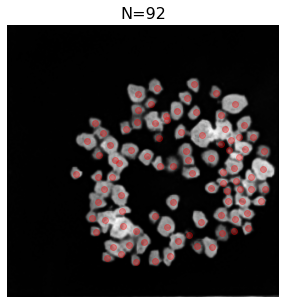

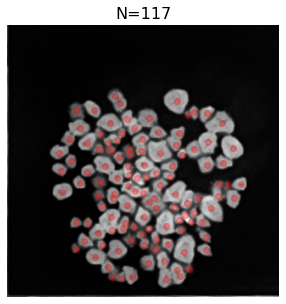

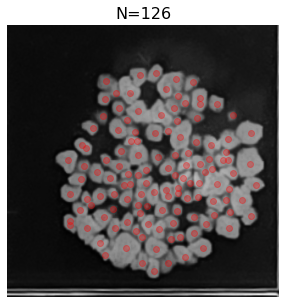

In [12]:
from edt import edt
from skimage.feature import peak_local_max
colony_counts = []
for i,p in enumerate(crops):
    loc = peak_local_max(edt(p[1][0][:,:,2]>0.5),min_distance=4,threshold_rel=0.08,threshold_abs=1)
    fig=plt.figure(figsize=(5,5))
    plt.imshow(p[0],cmap='gist_gray')
    plt.scatter(loc[:,1],loc[:,0],color='r',alpha=0.3)
    colony_counts.append(len(loc))
    plt.axis('off')
    plt.title('N={}'.format(len(loc)),fontsize=16)
    plt.savefig('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/counts_{}.png'.format(i),bbox_inches='tight')

In [75]:
colony_counts

[90, 111, 122]

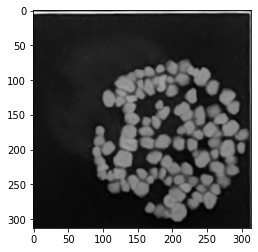

In [310]:
plt.imshow(crops[2][0],cmap='gist_gray')
#plt.scatter(loc[:,1],loc[:,0],color='r',alpha=0.3)